In [8]:
from StockTrade import StockTradeDiscrete
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
import gym
import numpy as np
import pandas as pd
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from StockTrade import StockTrade
import os
import gym
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import HER, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.bit_flipping_env import BitFlippingEnv
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.obs_dict_wrapper import ObsDictWrapper

In [9]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

In [10]:
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

In [11]:
env_raw = StockTradeDiscrete()
env = Monitor(env_raw, log_dir)

Using cuda device
Wrapping the env in a DummyVecEnv.
Num timesteps: 2500
Best mean reward: -inf - Last mean reward per episode: -169.38
Saving new best model to tmp/best_model
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -175     |
|    exploration rate | 0.62     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9837     |
|    time_elapsed     | 0        |
|    total timesteps  | 4000     |
----------------------------------
Num timesteps: 5000
Best mean reward: -169.38 - Last mean reward per episode: -169.80
Num timesteps: 7500
Best mean reward: -169.38 - Last mean reward per episode: -168.57
Saving new best model to tmp/best_model
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -164     |
|    exploration rate | 0.24     |
| time/               |          |
|    episodes    

Num timesteps: 57500
Best mean reward: -155.75 - Last mean reward per episode: -152.23
Saving new best model to tmp/best_model
Num timesteps: 60000
Best mean reward: -152.23 - Last mean reward per episode: -147.14
Saving new best model to tmp/best_model
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | -136     |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 60       |
|    fps              | 1638     |
|    time_elapsed     | 36       |
|    total timesteps  | 60000    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.13     |
|    n_updates        | 2499     |
----------------------------------
Num timesteps: 62500
Best mean reward: -147.14 - Last mean reward per episode: -143.85
Saving new best model to tmp/best_model
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 

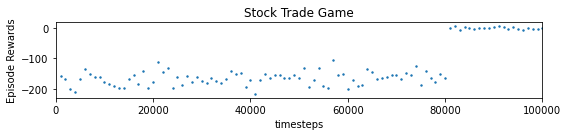

In [15]:
model = DQN(MlpPolicy, env, verbose=1)
callback = SaveOnBestTrainingRewardCallback(check_freq=2500, log_dir=log_dir)
timesteps = 100000

model.learn(total_timesteps=int(timesteps), callback=callback)
plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "Stock Trade Game")
plt.show()
model.save("123Automator")

In [16]:
obs = env.reset()
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()